In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import timedelta
import calendar
import datetime

In [2]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
# внешние ссылки на таблицы
customers_id_url = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
orders_url       = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
order_items_url  = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [4]:
# подготовка ссылок для загрузки в датафреймы
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Получаем загрузочную ссылку
customers_id_final_url = base_url + urlencode(dict(public_key=customers_id_url))
response = requests.get(customers_id_final_url)
customers_id_download_url = response.json()['href']

orders_final_url = base_url + urlencode(dict(public_key=orders_url))
response = requests.get(orders_final_url)
orders_download_url = response.json()['href']

order_items_final_url = base_url + urlencode(dict(public_key=order_items_url))
response = requests.get(order_items_final_url)
order_items_download_url = response.json()['href']


In [5]:
# загрузка датафреймов для проекта, даты приводим в корректный формат
customers_id_df = pd.read_csv(customers_id_download_url)
orders_df = pd.read_csv(orders_download_url, 
                              parse_dates=['order_purchase_timestamp', 
                                           'order_approved_at',
                                          'order_delivered_carrier_date',
                                          'order_delivered_customer_date',
                                          'order_estimated_delivery_date'])
order_items_df = pd.read_csv(order_items_download_url, 
                                   parse_dates=['shipping_limit_date'])

# 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

Здесь нас интересует количество уникальных пользователей совершивших покупку (customer_unique_id)

На основе опыта взаимодействия с интернет-магазинами,
фактами совершения покупки будем считать заказы со статусами:\
delivered - т.к. уже доставлено, а значит и оплачено \
shipped - т.к. товар отгружен со склада, а значит и оплачен \
processing - т.к. заказ собирается, а значит проведен платеж \
approved - т.к. заказ подтвержден, вероятно фактом оплаты

In [6]:
orders_df.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [7]:
# создаем функцию аггрегирования статусов по признаку "оплачено"
# 1 - оплачено
# 0 - не оплачено
def status (order_status):
    if order_status == 'delivered' \
    or order_status == 'shipped' \
    or order_status == 'processing' \
    or order_status == 'approved':
        return 1
    else:
        return 0

In [8]:
# создаем колонку с аггрегацией признака оплаченного заказа
orders_df['payed'] = orders_df.order_status.apply(status)

In [9]:
# смотрим размер таблицы 
orders_df.shape

(99441, 9)

In [10]:
# проверяем на дубликаты
orders_df.drop_duplicates().shape

(99441, 9)

In [11]:
# проверяем на пропущенные значения
# видим что есть пропуски по датам доставки и датам подтверждения заказа
# * еще не доставленные
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
payed                               0
dtype: int64

In [12]:
# аналогично проверяем по другой таблице
customers_id_df.shape

(99441, 5)

In [13]:
customers_id_df.drop_duplicates().shape

(99441, 5)

In [14]:
# сверяем количество уникальных пользователей
# все нормально
customers_id_df.customer_id.nunique()

99441

In [15]:
# проверяем на пропущенные значения
# их нет - все хорошо
customers_id_df.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [16]:
# на всякий случай проверяем дублирование информации группировкой покупок по времени покупки
# видим, что есть покупки с совпадением по времени до секунд
# проверим, что это за покупки и действительно ли они уникальны чуть позже,
# после объединения таблиц
in_1_time_orders = orders_df.groupby('order_purchase_timestamp', as_index=False) \
            .agg({'order_id': 'count'}) \
            .sort_values('order_id', ascending=False)
in_1_time_orders.head(30)

,order_purchase_timestamp,order_id
80050,2018-06-01 13:39:44,3
91448,2018-07-28 13:11:22,3
68536,2018-04-11 10:48:14,3
92723,2018-08-02 12:06:09,3
92722,2018-08-02 12:06:07,3
66153,2018-03-31 15:08:21,3
35212,2017-11-20 10:59:08,3
35256,2017-11-20 11:46:30,3
56573,2018-02-19 15:37:47,3
92708,2018-08-02 12:05:26,3


In [17]:
# сводим 2 таблицы orders_df и customers_id_df по значению customer_id
orders_and_customers = orders_df.merge(customers_id_df, on='customer_id', how='outer')
orders_and_customers

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payed,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [18]:
# Дополнительно смотрим на пропуски:
# замечаем, что даже у статусов заказов "доставлено" есть пропуски по времени подтверждения заказа.
# Но так как мы завели условие по статусу заказов, это не должно стать проблемой для этой задачи
orders_df.loc[orders_and_customers.order_approved_at.isna()] \
                    .sort_values('payed', ascending=False)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payed
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,1
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,1
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,1
72407,3c0b8706b065f9919d0505d3b3343881,d85919cb3c0529589c6fa617f5f43281,delivered,2017-02-17 15:53:27,NaT,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23,1
63052,51eb2eebd5d76a24625b31c33dd41449,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,1
...,...,...,...,...,...,...,...,...,...
32691,1a5d21f44c73693b9930d0ca33a9d0b1,a21871375ed19fc3f2d8c62fdc75b9dc,canceled,2018-08-16 17:50:14,NaT,NaT,NaT,2018-09-12,0
32733,4641a7999ca05850ee60509c213dc8ac,a7ff2f7795c7e202a24fc881252112bf,canceled,2017-11-20 12:48:37,NaT,NaT,NaT,2017-12-01,0
33650,fd4c3a2912e854eedd463b329540da4b,d2fdd1d3725bccaa0900e360a985398f,canceled,2017-10-28 11:18:48,NaT,NaT,NaT,2017-11-21,0
33979,5aac76cf7b07dd06fa4d50bf461d2f40,7a8a02e54cf3472df427e927f8b9c046,canceled,2018-09-25 11:59:18,NaT,NaT,NaT,2018-10-11,0


In [19]:
# аналогичные пропуски были до объедиения ранее
orders_and_customers.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
payed                               0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [20]:
# проверяем по нескольким датам из предыдущей агрегации (in_1_time_orders)
# заказы секунда в секунда относятся к одному уникальному покупателю (customer_unique_id)
orders_and_customers.loc[orders_and_customers.order_purchase_timestamp 
                                                     == '2018-03-31 15:08:21']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payed,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
3460,41c284ffd871324eadf06fc989583619,b2455d365185ab7c1da94e742e4976ad,delivered,2018-03-31 15:08:21,2018-03-31 16:20:04,2018-04-03 17:06:12,2018-04-13 19:58:36,2018-05-04,1,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG
51063,ef66cc60de5221417b5fb81b1c42de85,226d59f9f4b98e228b689eea45d03a6d,delivered,2018-03-31 15:08:21,2018-03-31 16:20:05,2018-04-03 16:31:15,2018-04-06 19:06:35,2018-05-04,1,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG
63380,8e17072ec97ce29f0e1f111e598b0c85,9e29cde4ddb42f9330bcf3c9bc23d177,delivered,2018-03-31 15:08:21,2018-03-31 15:50:11,2018-04-03 15:58:24,2018-04-06 17:38:34,2018-05-04,1,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG


Из предыдущей ячейки можно сделать вывод, что есть пользователи, которые совершили несколько одномоментных заказов.
Формально ответ на поставленный вопрос задания будет в следующей ячейке.

In [21]:
# вычисляем количество уникальных пользователей (customer_unique_id) с 1 совершенной покупкой
# *(оплаченный заказ):
# группируем по customer_unique_id
# суммируем по признак "оплачено"
# оставляем только равные единице (один раз совершена покупка уникальным пользователем)
# выводим сумму уникальных клиентов с одной покупкой
orders_and_customers.groupby('customer_unique_id', as_index=False) \
                        .agg({'payed': 'sum'}) \
                        .query('payed == 1') \
                        .shape[0]

91816

Но вопрос бизнеса может стоять наверное и в другом: сколько уникальных пользователей совершили 1 покупку как таковую. 
Т.е. можно попробовать не делить покупки по заказам если они сделаны одномоментно.

In [22]:
# Т.е. мы группируем уже в т.ч. по времени покупки, делаем аналогичную аггрегацию
# и оставляем так же только с признаком совершения одной покупки
# но выводим количество уникальных покупателей безотносительно количества заказов в один момент 
# (объединяем)
# Это значит, что количество таких покупателей увеличивается, а количество покупателей с более 1-ой
# покупкой сокращается
orders_and_customers.groupby(['customer_unique_id', 
                              'order_purchase_timestamp'], as_index=False) \
                        .agg({'payed': 'sum'}) \
                        .query('payed == 1') \
                        .customer_unique_id.nunique()

94439

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

Я покажу решение вопроса как он есть по заданию далее (в конце)\
Сейчас же я попробую решить как мне кажется более интересный вопрос

Переформулирую/уточню формулировку задачи: 
Сколько заказов в среднем в месяц допускают срыв обещанного срока по доставке? 
Определить причины срывов и вывести детализацию.
Т.е. мы опять будем работать со статусами "payed", т.е. с валидными заказами.
Дальше я поясню, почему не счел необходимым рассматривать остальные статусы.

Под заказом мы понимаем order_id безотносительно количества входимых в него order_item_id

In [23]:
# для начала посмотрим на оставшуюся таблицу
order_items_df.shape

(112650, 7)

In [24]:
order_items_df.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [25]:
order_items_df.drop_duplicates().shape

(112650, 7)

In [26]:
# объединяем таблицы для включения всей информации по датам между переходами при совершении покупки
overall_df = orders_and_customers.merge(order_items_df, on='order_id', how='outer')
overall_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payed,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [27]:
# видим что появились незаполненные данные по 775 order_id
overall_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
payed                               0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
dtype: int64

In [28]:
# смотрим, что из себя они представляют:
# в большей части это касается недоступных товаров или отмененных заказов
# поэтому для нашей задачи эти заказы не важны и их в последующем уберем из выборки
# Но есть несколько заказов по всей видимости с ошибками при занесении в БД (invoiced, shipped)
# количество не большое, но Дата-инженерам следует на эти ошибки обратить внимание
overall_df.loc[overall_df.order_item_id.isna()].order_status.value_counts()

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

In [29]:
# Здесь мы видим распределение по всем статусам за рассматриваемый период
# Считаю, что статусы canceled (пользователем) и unavailable (разные могут быть причины), 
# мало интересны для задач бизнеса. Доля незначительна и мы не сможем на нее напрямую повлиять
# А как раз проблема со временем (своевременностью) доставки важна и необходимо понять причины срыва 
# сроков, т.к. это напрямую связано с удовлетворенностью пользователей.
overall_df.order_status.value_counts(normalize=True).mul(100)

delivered      97.154067
shipped         1.045625
canceled        0.622438
unavailable     0.537800
invoiced        0.318272
processing      0.314745
created         0.004408
approved        0.002645
Name: order_status, dtype: float64

In [30]:
# дубликатов здесь возникнуть не должно было, но на всякий случай сверились с предыдущей размерностью
overall_df.drop_duplicates().shape

(113425, 19)

In [31]:
# добавляем колонки:
# total_shipping_diff - общее время задержки доставки от обещанного срока (дни)
# carrier_deliver_shipping_diff - время задержки продавцом доставки до почтовой службы (дни)
overall_df['total_shipping_diff'] = (overall_df.order_delivered_customer_date 
                               - overall_df.order_estimated_delivery_date) \
                                .dt.days
overall_df['carrier_deliver_shipping_diff'] = (overall_df.order_delivered_carrier_date 
                               - overall_df.shipping_limit_date) \
                                .dt.days

In [32]:
# создаем датафрейм для последующей обработки
# фильтр по оплаченным заказам payed == 1 и по просроченным заказам total_shipping_diff > 0
# Видим, что в 1-ой строке нет данных по времени доставки в логистическую службу.
late_cause_df = overall_df.query(('payed == 1') and ('total_shipping_diff > 0'))
late_cause_df.query('carrier_deliver_shipping_diff.isna()')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payed,customer_unique_id,...,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_shipping_diff,carrier_deliver_shipping_diff
83453,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14,1,a2ac81ecc3704410ae240e74d4f0af40,...,indaiatuba,SP,1.0,44c2baf621113fa7ac95fa06b4afbc68,3f2af2670e104d1bcb54022274daeac5,2017-10-18 10:07:16,179.0,14.98,6.0,NaN


In [33]:
# Т.к. определить причину срыва срока мы не можем однозначно, можем удалить строку.
# 1 строка не повлияет на общую картину распределения
late_cause_df = late_cause_df.dropna()
# оставляем только уникальные order_id (фильтр через ключ по первому номеру в заказе order_item_id)
# т.к. в 1 заказе могло быть несколько item 
late_cause_df = late_cause_df.query('order_item_id == 1.0')

In [34]:
# сбрасываем индексы для порядка
late_cause_df.reset_index(drop=True, inplace=True)

In [35]:
# смотрим (для себя) топ-10 значений (total_shipping_diff) по просрокам за весь доступный период
late_cause_df.sort_values('total_shipping_diff', ascending=False).head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payed,customer_unique_id,...,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_shipping_diff,carrier_deliver_shipping_diff
3637,1b3190b2dfa9d789e1f14c05b647a14a,d306426abe5fca15e54b645e4462dc7b,delivered,2018-02-23 14:57:35,2018-02-23 15:16:14,2018-02-26 18:49:07,2018-09-19 23:24:07,2018-03-15,1,eb21169c3153a2b507fc7e76d561ff14,...,rio de janeiro,RJ,1.0,ee406bf28024d97771c4b1e8b7e8e219,7a67c85e85bb2ce8582c35f2203ad736,2018-03-01 15:16:14,144.99,17.26,188.0,-3.0
1308,ca07593549f1816d26a572e06dc1eab6,75683a92331068e2d281b11a7866ba44,delivered,2017-02-21 23:31:27,2017-02-23 02:35:15,2017-03-08 13:47:46,2017-09-19 14:36:39,2017-03-22,1,4a2519b6991378f6f2ce5ed22d308f03,...,montanha,ES,1.0,8eed5d27f5b8c6248731efb4782f6141,2a1348e9addc1af5aaa619b1a3679d6b,2017-02-25 23:31:27,229.90,15.78,181.0,10.0
790,47b40429ed8cce3aee9199792275433f,cb2caaaead400c97350c37a3fc536867,delivered,2018-01-03 09:44:01,2018-01-03 10:31:15,2018-02-06 01:48:28,2018-07-13 20:51:31,2018-01-19,1,4cb8ad9a4554099db7d70c13d0dae906,...,salto,SP,1.0,ebf1c13032246ea801765e8cb5417365,cb41bfbcbda0aea354a834ab222f9a59,2018-01-09 10:31:15,399.00,54.33,175.0,27.0
5330,2fe324febf907e3ea3f2aa9650869fa5,65b14237885b3972ebec28c0f7dd2220,delivered,2017-03-13 20:17:10,2017-03-13 20:17:10,2017-03-17 07:23:53,2017-09-19 17:00:07,2017-04-05,1,78d26ae26b5bb9cb398edc7384d3c15f,...,paulinia,SP,1.0,b75683e29689c1a989ae97883e8cad56,df683dfda87bf71ac3fc63063fba369d,2017-03-17 20:17:10,39.90,16.05,167.0,-1.0
5862,285ab9426d6982034523a855f55a885e,9cf2c3fa2632cee748e1a59ca9d09b21,delivered,2017-03-08 22:47:40,2017-03-08 22:47:40,2017-03-09 08:53:20,2017-09-19 14:00:04,2017-04-06,1,3c2564d42f7ddd8b7576f0dd9cb1b4c5,...,lagarto,SE,1.0,0c6fc9b9317a68d1cda098c063914b72,c847e075301870dd144a116762eaff9a,2017-03-16 22:47:40,429.90,27.75,166.0,-8.0
4019,440d0d17af552815d15a9e41abe49359,7815125148cfa1e8c7fee1ff7974f16c,delivered,2017-03-07 23:59:51,2017-03-09 01:11:33,2017-03-15 13:00:08,2017-09-19 15:12:50,2017-04-07,1,f0785d41d416fa827f24c4b95d066b69,...,belem,PA,1.0,3bec03860f3782ef8993056e01b8229a,2a1348e9addc1af5aaa619b1a3679d6b,2017-03-15 01:11:33,159.90,25.12,165.0,0.0
4503,c27815f7e3dd0b926b58552628481575,f85e9ec0719b16dc4dd0edd438793553,delivered,2017-03-15 23:23:17,2017-03-15 23:23:17,2017-03-21 14:50:25,2017-09-19 17:14:25,2017-04-10,1,e7834c7e017fb854ac65189a66c33132,...,perdizes,MG,1.0,05e8eca656b87428a0e8453a2f335cdf,054694fa03fe82cec4b7551487331d74,2017-03-26 23:23:17,487.00,48.90,162.0,-6.0
2656,d24e8541128cea179a11a65176e0a96f,beeda72b31be3b8a38b5c2b77d7705c4,delivered,2017-06-12 13:14:11,2017-06-12 13:25:11,2017-06-16 14:44:37,2017-12-04 18:36:29,2017-06-26,1,beba456e33133cc65b481399d051b2ba,...,sao bernardo do campo,SP,1.0,a224196b0b605fdffac1d9224f052ceb,cac4c8e7b1ca6252d8f20b2fc1a2e4af,2017-06-16 13:25:11,19.99,11.73,161.0,0.0
2495,0f4519c5f1c541ddec9f21b3bddd533a,1a8a4a30dc296976717f44e7801fdeef,delivered,2017-03-09 13:26:57,2017-03-09 13:26:57,2017-03-22 05:28:14,2017-09-19 14:38:21,2017-04-11,1,4df2d7257a7463e2d7a98a5b08cb92fc,...,teresina,PI,1.0,e0d64dcfaa3b6db5c54ca298ae101d05,7e93a43ef30c4f03f38b393420bc753a,2017-03-15 13:26:57,231.27,27.88,161.0,6.0
3556,2d7561026d542c8dbd8f0daeadf67a43,8199345f57c6d1cbe9701f92481beb8d,delivered,2017-03-15 11:24:27,2017-03-15 11:24:27,2017-03-16 09:29:16,2017-09-19 14:38:18,2017-04-13,1,186a453a38d349c487ccbf472b31fb39,...,aracaju,SE,1.0,7594c5fa74bceda1c2540003533a6e02,e83c76265fc54bf41eac728805e4da77,2017-03-21 11:24:27,32.90,20.80,159.0,-6.0


In [36]:
# опять же для себя вывожу информацию по квантилям распределения дней срыва сроков доставки
late_quant_25 = round(late_cause_df.total_shipping_diff.quantile(0.25))
late_quant_50 = round(late_cause_df.total_shipping_diff.quantile(0.5))
late_quant_75 = round(late_cause_df.total_shipping_diff.quantile(0.75))
print(f'25% опазданий доставки имеют срок задержки доставки заказа \
до {late_quant_25} дней')
print(f'50% опазданий доставки имеют срок задержки доставки заказа \
до {late_quant_50} дней')
print(f'75% опазданий доставки имеют срок задержки доставки заказа \
до {late_quant_75} дней')

25% опазданий доставки имеют срок задержки доставки заказа до 3 дней
50% опазданий доставки имеют срок задержки доставки заказа до 7 дней
75% опазданий доставки имеют срок задержки доставки заказа до 13 дней


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


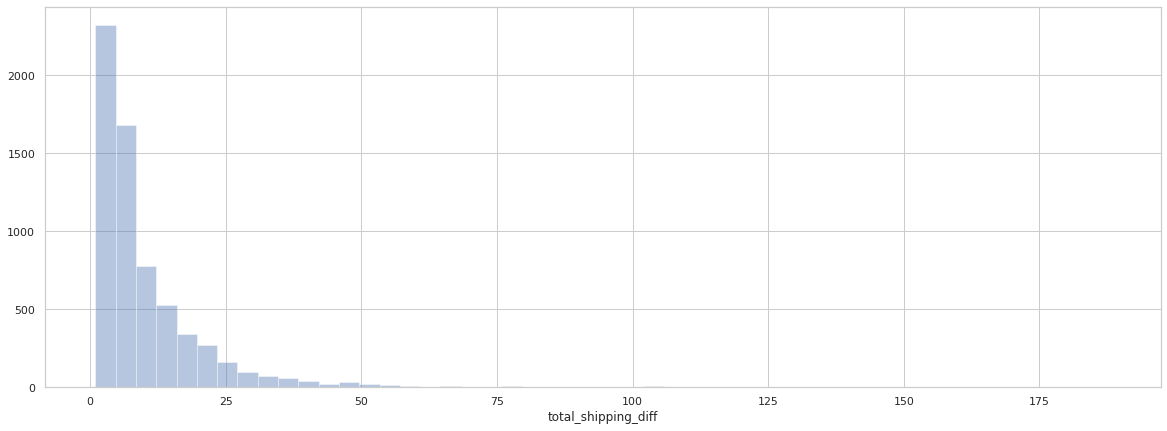

In [37]:
# строим для себя график распределения количества дней опоздания за весь период
sns.distplot(late_cause_df.total_shipping_diff, kde=False)

In [38]:
# создаем функцию вычисления причины опаздания доставки по причине ПОЧТА
def post_cause (value):
    if value <= 0:
        return True
    else:
        return False

In [39]:
# переводим тип float в int (для красоты)
late_cause_df.carrier_deliver_shipping_diff = late_cause_df \
                        .carrier_deliver_shipping_diff \
                        .astype(int)
late_cause_df.total_shipping_diff = late_cause_df \
                        .total_shipping_diff \
                        .astype(int)

In [40]:
# применяем ранее созданную функцию и записываем булевы значения причины задержки доставки ПОЧТА
late_cause_df['post_cause'] = late_cause_df \
                                    .carrier_deliver_shipping_diff \
                                    .apply(post_cause)

In [41]:
# применяем ранее созданную функцию и записываем булевы значения причины задержки доставки ПРОДАВЕЦ
late_cause_df['seller_cause'] = late_cause_df.total_shipping_diff \
                                <= late_cause_df.carrier_deliver_shipping_diff

In [42]:
# применяем ранее созданную функцию и записываем булевы значения причины задержки доставки 
# ПОЧТА и ПРОДАВЕЦ
late_cause_df['seller_and_post'] = (late_cause_df.total_shipping_diff \
                                > late_cause_df.carrier_deliver_shipping_diff) \
                                *(late_cause_df.carrier_deliver_shipping_diff > 0)

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [43]:
# Создаем таблицу продавцов с распределением количества опозданий по доставке товара на почту 
late_seller_list = late_cause_df.loc[late_cause_df.seller_cause==True] \
                                .groupby('seller_id', as_index=False) \
                                .agg({'seller_cause': 'count'}) \
                                .sort_values('seller_cause', ascending=False)
# Выводим топ-10
late_seller_list.head(10)

,seller_id,seller_cause
8,06a2c3af7b3aee5d69171b0e14f0ee87,31
16,1025f0e2d44d7041d6cf58b6550e0bfa,28
179,88460e8ebdecbfecb5f9601833981930,23
103,54965bbe3e4f07ae045b90b0b8541f52,19
58,2eb70248d66e0e3ef83659f71b244378,13
223,a49928bcdf77c55c6d6e05e09a9b4ca5,13
254,beadbee30901a7f61d031b6b686095ad,12
159,7c67e1448b00f6e969d365cea6b010ab,10
237,b1b3948701c5c72445495bd161b83a4c,8
141,6fd52c528dcb38be2eea044946b811f8,8


In [44]:
# Выясняем, что 97% всех срывов сроков допустили указанные выше продавцы
late_seller_list.quantile(0.97)

seller_cause    8.0
Name: 0.97, dtype: float64

In [45]:
# Сравним этих продавцов с топ-10 по проданным заказам:
# Ни одного из опаздывающих в предыдущей выборке нет в топе
# Вероятно высокая загрузка продавца не является основной причиной.
# Необходимо провести работу с топ-10 продавцами late_seller_list для исключения 
# просроков в дальнейшем - это важно для лояльности покупателей
overall_df.query('payed == 1').loc[overall_df.order_item_id==1] \
                                .groupby('seller_id', as_index=False) \
                                .agg({'order_item_id': 'count'}) \
                                .sort_values('order_item_id', ascending=False) \
                                .head(10)

,seller_id,order_item_id
1209,6560211a19b47992c3666cc44a7e94c0,1834
867,4a3ca9315b744ce9f8e9374361493884,1757
2438,cc419e0650a3c5ba77189a1882b7556a,1687
363,1f50f920176fa81dab994f9023523100,1388
2598,da8622b14eb17ae2831f4ac5b9dab84a,1298
1788,955fee9216a65b617aa5c0531780ce60,1278
1475,7a67c85e85bb2ce8582c35f2203ad736,1149
2785,ea8482cd71df3c1969d7b9473ff13abc,1135
843,4869f7a5dfa277a7dca6462dcf3b52b2,1124
718,3d871de0142ce09b7081e2b9d1733cb1,1064


In [46]:
# общее количество просрочек по доставке по причине почтовых служб за все время
late_cause_df.post_cause.sum()

5216

In [47]:
# общее количество просрочек по доставке по причине поздней доставки продавцов до почтовой службы
# за все время
late_cause_df.seller_cause.sum()

760

In [48]:
# общее количество просрочек по доставке по причине обоюдной задержки (почта и продавец) за все время
late_cause_df.seller_and_post.sum()

558

In [49]:
# сводим ранее полученные причины в одну колонку
late_cause_df['cause'] = 0
for i in range (0,late_cause_df.shape[0]):
    if late_cause_df.post_cause[i] == True:
        late_cause_df['cause'][i] = 'post'
    elif late_cause_df.seller_cause[i] == True:
        late_cause_df['cause'][i] = 'seller'
    elif late_cause_df.seller_and_post[i] == True:
        late_cause_df['cause'][i] = 'seller_and_post'

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/tljh/user/lib/python3.7/site-p

In [50]:
# проверяем, что все перевелось корректно
late_cause_df.cause.value_counts()

post               5216
seller              760
seller_and_post     558
Name: cause, dtype: int64

In [51]:
# добавляем колонки с распарсенной датой обещанной доставки
late_cause_df['period'] = late_cause_df.order_delivered_customer_date \
                                             .dt.strftime('%Y-%m')
late_cause_df['period_month'] = late_cause_df.order_delivered_customer_date \
                                             .dt.strftime('%m')
late_cause_df['period_year'] = late_cause_df.order_delivered_customer_date \
                                            .dt.strftime('%Y')

In [52]:
# создаем таблицу с разбивкой по месяцам/причинам и суммой просроченных заказов
late_period_df = late_cause_df.groupby(['period', 'cause'], as_index=False) \
             .agg({'order_id': 'count'}) \
             .rename(columns={'order_id': 'late_sum'})
late_period_df

,period,cause,late_sum
0,2016-11,seller,2
1,2016-12,seller,1
2,2017-02,seller,1
3,2017-03,post,27
4,2017-03,seller,21
...,...,...,...
56,2018-08,seller_and_post,100
57,2018-09,post,42
58,2018-09,seller,7
59,2018-09,seller_and_post,7


In [53]:
# подгатавливаем данные для сравнения всех количества всех заказов с просроченными
all_df = overall_df.query(('payed == 1')) \
                          .dropna() \
                          .copy()
# оставляем только уникальные order_id (фильтр через ключ по первому номеру в заказе order_item_id)
all_df = all_df.query('order_item_id == 1.0')
all_df['period'] = all_df.order_delivered_customer_date \
                                             .dt.strftime('%Y-%m')

In [54]:
# данные для графика: периоды по месяцам и сумма всех валидных заказов
all_bar = all_df.groupby(['period'], as_index=False).agg({'payed': 'sum'})

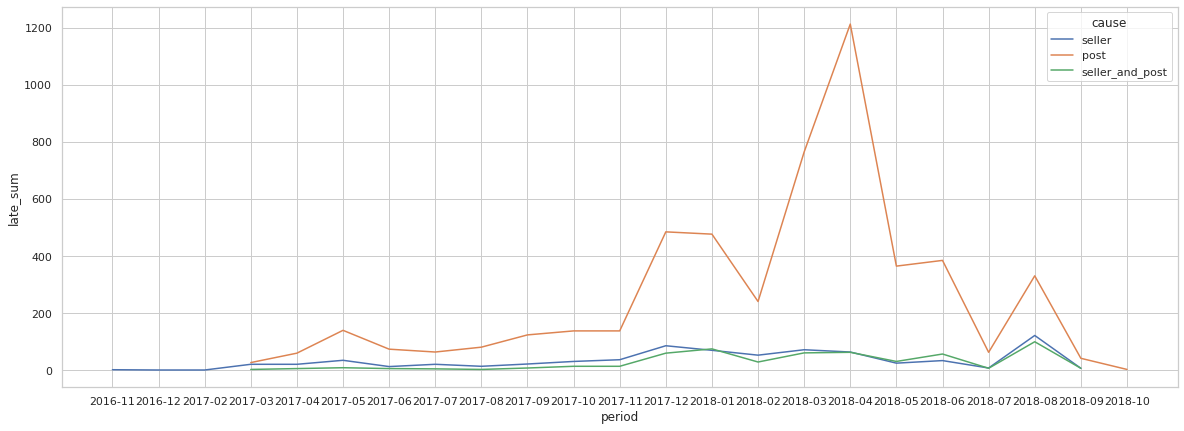

In [55]:
# Строим график по месяцам с разбивкой по причинам
# Как видно из графика: с декабря 2017 года по август 2018 произошел аномальный рост 
# срывов сроков доставок по причине почтовой службы
# По остальным причинам выраженной динамики или больших выбросов не наблюдается
sns.lineplot(x='period', y='late_sum', data=late_period_df, hue='cause')
# можно раскомментировать код ниже для наложения общего количества с количеством срывов 
# сроков доставки
# sns.barplot(x='period', y='payed', data=all_bar)

Нельзя однозначно утверждать, что задержки связаны с возросшим количеством заказов:
1. Рост задержек начался до значительного роста количества заказов
2. Задержки были снижены после августа 2018 года несмотря на большое количество заказов в работе

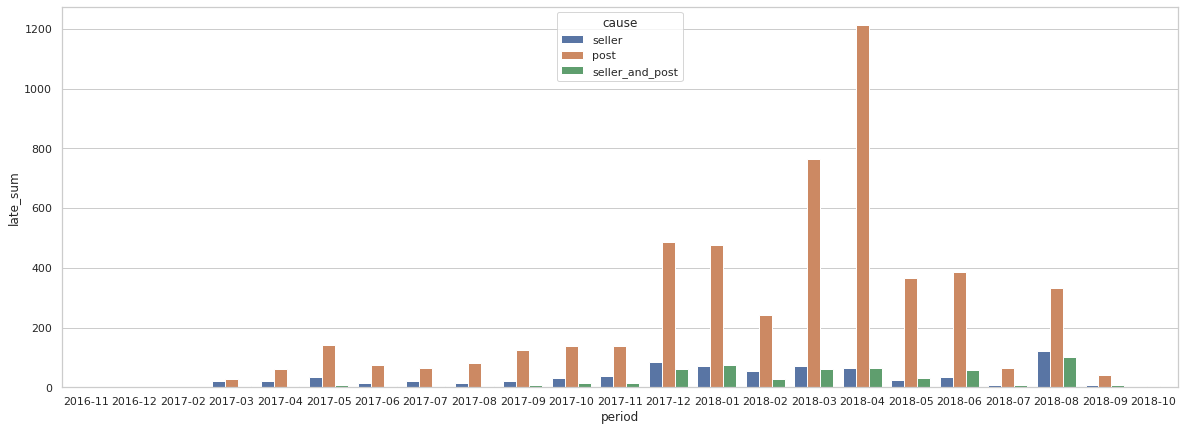

In [56]:
# Тот же график, но в виде барплота
sns.barplot(data=late_period_df, hue='cause', x='period', y='late_sum')

In [57]:
# Наконец выводим таблицу требуемую по заданию:

# Делаем группировки по году, месяцу и причине
mean_df = late_cause_df.groupby(['period_year', 'period_month', 
                                 'cause'], as_index=False) \
                        .agg({'order_id': 'count'}) \
                        .rename(columns={'order_id': 'late_sum'})
# Создаем новую таблицу с новыми колонками "summary"
summary = mean_df.groupby(['period_year', 'cause'], as_index=False) \
                 .agg({'late_sum': 'sum'})
# Добавляем колонку с количеством месяцев рассматриваемых периодов
# т.к. есть отсутствующие месяцы в дф, делаю вручную т.к. всего 3 периода (3 года)
summary['num_of_month'] = 0
for i in range (0,summary.shape[0]):
    if summary.period_year[i] == '2016':
        summary['num_of_month'][i] = 2
    elif summary.period_year[i] == '2017':
        summary['num_of_month'][i] = 12
    elif summary.period_year[i] == '2018':
        summary['num_of_month'][i] = 10
# Рассчитываю для каждого года и каждой причины свое значение среднего количества заказов 
# доставленных не в срок (late_mean_in_month_by_cause)
# Важно: так как ранее мы видели, что есть разница по годам, то делаю разбивку и годам в т.ч. 
# (хоть это и не определено в задании)
summary['late_mean_in_month_by_cause'] = round((summary.late_sum / 
                                                summary.num_of_month), 1)
summary

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,period_year,cause,late_sum,num_of_month,late_mean_in_month_by_cause
0,2016,seller,3,2,1.5
1,2017,post,1331,12,110.9
2,2017,seller,302,12,25.2
3,2017,seller_and_post,128,12,10.7
4,2018,post,3885,10,388.5
5,2018,seller,455,10,45.5
6,2018,seller_and_post,430,10,43.0


Ответ: 
в предыдущей ячейке мы вывели требуемые значения средних показателей количества недоставленных товаров в месяц с разбивкой по причинам и в разрезе годов (late_mean_in_month_by_cause).

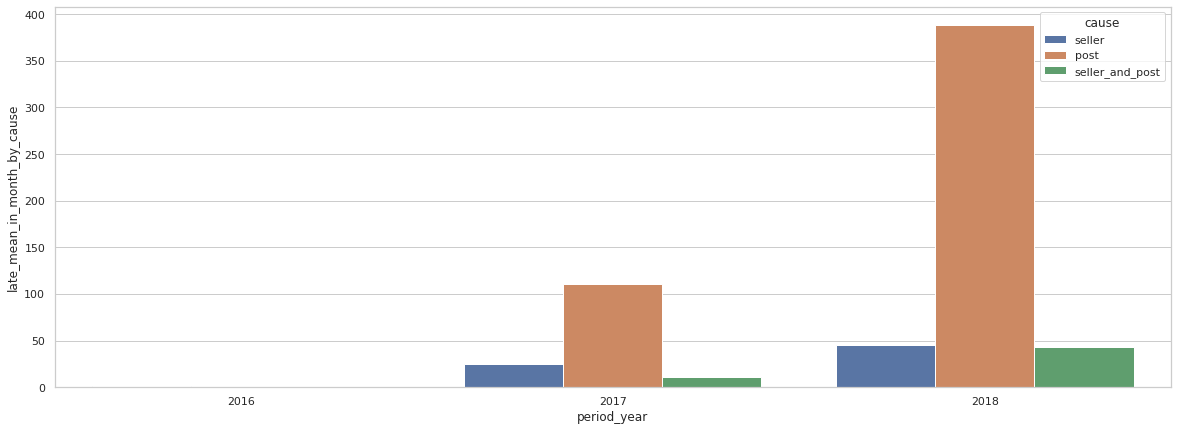

In [58]:
# График распределения среднего количества заказов со срывом сроков доставки в месяц
# с разбивкой по годам и причинам
sns.barplot(data=summary, hue='cause', x='period_year', y='late_mean_in_month_by_cause')

# Но если не пытаться перефразировать вопрос:
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?\
А вывести среднее количество недоставленных заказов (order_status != 'delivered')

In [59]:
#добавляем колонку периода год-месяц
overall_df[['order_month']] = overall_df.order_purchase_timestamp.dt.to_period('M')

#исключаем статусы "доставлено"
overall_df2 = overall_df.query("order_status != 'delivered'")

#делим количество причин недоставок и делим на количество месяцев во все периоде
overall_df2.order_status.value_counts() / overall_df2.order_month.nunique()
# получаем средние значения в месяц

shipped        49.416667
canceled       29.416667
unavailable    25.416667
invoiced       15.041667
processing     14.875000
created         0.208333
approved        0.125000
Name: order_status, dtype: float64

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

Здесь нас интересуют строки и значения product_id (код продукта) и order_purchase_timestamp (время создания заказа).

In [60]:
# Но для начала мы сделаем фильтр только по оплаченным позициям по аналогии ранее (payed==1)
order_weekday_df = overall_df.query('payed == 1')

In [61]:
# количество уникальных product_id
order_weekday_df.product_id.nunique()

32616

In [62]:
# создаем колонку с днем недели для каждого заказа
order_weekday_df['weekday_purchase'] = order_weekday_df \
                                        .order_purchase_timestamp \
                                        .dt.day_name()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
# Сначала группируем все значения по коду продукта (product_id) и дню недели покупки,
# аггрегируем по произвольной колонке с подсчетом количества,
# переименовываем колонку с суммой по дням недели (product_weekday_count),
# сортируем по колонке product_weekday_count от большего к меньшему,
# удаляем дубликаты по product_id с ключом keep='first' - оставить первое значение
# В нашем случае это наибольшее т.к. мы отсортировали предварительно
top_weekday_product_id = order_weekday_df \
                .groupby(['product_id', 'weekday_purchase'], as_index=False) \
                .agg({'seller_id' : 'count'}) \
                .rename(columns={'seller_id': 'product_weekday_count'}) \
                .sort_values('product_weekday_count', ascending=False) \
                .drop_duplicates(subset='product_id', keep='first')
top_weekday_product_id

,product_id,weekday_purchase,product_weekday_count
15766,422879e10f46682990de24d770e7f83d,Wednesday,93
36178,99a4788cb24856965c36a24e339b6058,Monday,92
40679,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19944,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12892,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
23813,64367bed3ed96fd9381676fbe33b6443,Sunday,1
23814,643a4049ae3e6df63858575f28cd7b21,Friday,1
23816,643a66b1dc5dad3de6cb5a41549e72f1,Sunday,1
23818,643f86cfb81c8ef89293524c5cd78435,Thursday,1


In [64]:
# проверяем на всякий случай, что количество уникальных product_id в изначальном df совпадает
order_weekday_df.product_id.nunique()

32616

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

Здесь нас интересует колонка идентификатора пользователя (customer_unique_id) и уникальный номер заказа (order_id). \
За дату совершения покупки возьмем order_purchase_timestamp, т.к. в последствии все равно отфильтруем только по валидным заказам.

In [65]:
# количество уникальных пользователей всего
overall_df.customer_unique_id.nunique()

96096

In [66]:
# Для начала опять оставляем только валидные заказы (подтвержденные, оплаченные, в сборке и т.д.
week_mean_customer_order = overall_df.query('payed == 1')
# Оставляем только заказы с order_item_id с номером 1, для исключения дублирования
week_mean_customer_order = week_mean_customer_order.query('order_item_id == 1')

In [67]:
# Создаем функцию расчета количества недель в месяце
def num_weeks (date):
    num = (calendar.monthrange(date.year, date.month)[1]) / 7
    return num

In [68]:
# Применяем функцию и создаем новую колонку со значениями
week_mean_customer_order['number_of_weeks_in_month'] = \
week_mean_customer_order.order_purchase_timestamp.apply(num_weeks)

In [69]:
# Добавляем колонки с распарсенной датой обещанной покупки
week_mean_customer_order['period'] = week_mean_customer_order.order_purchase_timestamp \
                                             .dt.strftime('%Y-%m')

In [70]:
# Проводим группировки необходимые и аггрегацию с подсчетом количества заказов для каждого клиента
week_mean_customer_order = week_mean_customer_order \
                    .groupby(['customer_unique_id', 
                              'period', 
                              'number_of_weeks_in_month'], as_index=False) \
                    .agg({'order_id': 'count'}) \
                    .rename(columns={'order_id': 'orders_sum'}) \
                    .sort_values('period')

In [71]:
# Вычисляем значение среднего количества покупок в неделю по месяцам для каждого пользователя
week_mean_customer_order['mean_order_per_week'] = \
week_mean_customer_order.orders_sum / week_mean_customer_order.number_of_weeks_in_month

In [72]:
# Выводим таблицу со средним значением покупок для каждого пользователя в неделю по месяцам 
# (mean_order_per_week) с сортировкой по дате
week_mean_customer_order.sort_values('period')

,customer_unique_id,period,number_of_weeks_in_month,orders_sum,mean_order_per_week
49543,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09,4.285714,1,0.233333
69436,b7d76e111c89f7ebf14761390f0f7d17,2016-09,4.285714,1,0.233333
25703,4403513209514871ac9d0fd681f7cdb5,2016-10,4.428571,1,0.225806
46462,7af2db50b8a1a1c7fdf77acb033ba6b0,2016-10,4.428571,1,0.225806
46141,7a2679d6c164f6b6a2f36daf1b2fbc9d,2016-10,4.428571,1,0.225806
...,...,...,...,...,...
50724,865dec7a34ed7880aef2046e4bdb0dbe,2018-08,4.428571,1,0.225806
50728,8660311748ba18cadc814eb18fe8472a,2018-08,4.428571,1,0.225806
50754,8674bb2f6b1541bf6562004e5ea684f1,2018-08,4.428571,1,0.225806
50763,867bd5d847441c4437493b52f60cca6f,2018-08,4.428571,1,0.225806


# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

In [73]:
# В очередной раз оставим только валидные строки с фактическими заказами
cohort = overall_df.query('payed == 1' and 'order_item_id==1')
cohort

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payed,customer_unique_id,...,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_shipping_diff,carrier_deliver_shipping_diff,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,7c396fd4830fd04220f754e42b4e5bff,...,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,-8.0,-2.0,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,af07308b275d755c9edb36a90c618231,...,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,-6.0,-4.0,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,3a653a41f6f9fc3d2a113cf8398680e8,...,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,-18.0,-5.0,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,7c142cf63193a1473d2e66489a9ae977,...,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,-13.0,-2.0,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,72632f0f9dd73dfee390c9b22eb56dd6,...,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,-10.0,-6.0,2018-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113419,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1,6359f309b166b0196dbf7ad2ac62bb5a,...,SP,1.0,ac35486adb7b02598c182c2ff2e05254,e24fc9fcd865784fb25705606fe3dfe7,2017-03-15 09:54:05,72.00,13.08,-11.0,-5.0,2017-03
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1,da62f9e57a76d978d02ab5362c509660,...,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,-2.0,-5.0,2018-02
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1,737520a9aad80b3fbbdad19b66b37b30,...,BA,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,-6.0,-8.0,2017-08
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1,5097a5312c8b157bb7be58ae360ef43c,...,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,-21.0,-1.0,2018-01


In [74]:
# Добавляем колонки с периодом покупки (год-месяц)
# и периодом первой покупки (год-месяц)
cohort['month'] = cohort['order_purchase_timestamp'].dt.to_period('M')
cohort['cohort'] = cohort.groupby('customer_unique_id')['order_purchase_timestamp'] \
                         .transform('min') \
                         .dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [93]:
cohort

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payed,customer_unique_id,...,product_id,seller_id,shipping_limit_date,price,freight_value,total_shipping_diff,carrier_deliver_shipping_diff,order_month,month,cohort
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,7c396fd4830fd04220f754e42b4e5bff,...,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,-8.0,-2.0,2017-10,2017-10,2017-09
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,af07308b275d755c9edb36a90c618231,...,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,-6.0,-4.0,2018-07,2018-07,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,3a653a41f6f9fc3d2a113cf8398680e8,...,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,-18.0,-5.0,2018-08,2018-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,7c142cf63193a1473d2e66489a9ae977,...,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,-13.0,-2.0,2017-11,2017-11,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,72632f0f9dd73dfee390c9b22eb56dd6,...,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,-10.0,-6.0,2018-02,2018-02,2018-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113419,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1,6359f309b166b0196dbf7ad2ac62bb5a,...,ac35486adb7b02598c182c2ff2e05254,e24fc9fcd865784fb25705606fe3dfe7,2017-03-15 09:54:05,72.00,13.08,-11.0,-5.0,2017-03,2017-03,2017-03
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1,da62f9e57a76d978d02ab5362c509660,...,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,-2.0,-5.0,2018-02,2018-02,2018-02
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1,737520a9aad80b3fbbdad19b66b37b30,...,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,-6.0,-8.0,2017-08,2017-08,2017-08
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1,5097a5312c8b157bb7be58ae360ef43c,...,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,-21.0,-1.0,2018-01,2018-01,2018-01


In [75]:
# Производим аггрегацию по количеству покупателей по когортам
cohort_df = cohort.groupby(['cohort', 'month'], as_index=False) \
                  .agg(user_count=('customer_unique_id', 'nunique'))
# Добавляем колонку с количеством месяцев между периодом покупки и периодом первичной покупки
cohort_df['period_number'] = 12 * (cohort_df.month.dt.year - cohort_df.cohort.dt.year) + \
(cohort_df.month.dt.month - cohort_df.cohort.dt.month)

In [76]:
# Создаем пивот из когорт с данными по количеству покупателей от первого месяца и повторных покупок
cohort_pivot = cohort_df.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='user_count')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,305.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,754.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1705.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2595.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2339.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,4.0,NaN,NaN,NaN
2017-05,3560.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,10.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3114.0,15.0,11.0,12.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [77]:
# Строим пивот с retention на основе предыдущей таблицы
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003279,NaN,NaN,0.003279,NaN,0.003279,NaN,0.003279,NaN,0.003279,NaN,0.003279,0.006557,0.006557
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003979,0.002653,0.001326,0.003979,0.001326,0.003979,0.001326,0.001326,NaN,0.003979,0.001326,0.006631,0.003979,0.001326,0.001326,0.002653,0.003979,0.001326,NaN
2017-02,1.0,0.002346,0.002933,0.001173,0.004106,0.001173,0.002346,0.001760,0.001173,0.001760,0.001173,0.002933,0.001173,0.001760,0.001173,0.000587,0.000587,0.002346,NaN,NaN
2017-03,1.0,0.005010,0.003468,0.003854,0.003468,0.001541,0.001541,0.003083,0.003468,0.000771,0.003854,0.001156,0.002312,0.001156,0.001541,0.002312,0.000771,0.001541,NaN,NaN
2017-04,1.0,0.005985,0.002138,0.001710,0.003420,0.002565,0.003420,0.002993,0.002993,0.001710,0.002565,0.000855,0.000855,0.000428,0.000855,0.000855,0.001710,NaN,NaN,NaN
2017-05,1.0,0.004775,0.004775,0.003933,0.003090,0.003371,0.004213,0.001404,0.002528,0.002809,0.002528,0.003371,0.002528,0.000281,0.001966,0.002528,NaN,NaN,NaN,NaN
2017-06,1.0,0.004817,0.003532,0.003854,0.002569,0.003854,0.003854,0.002248,0.001285,0.002248,0.003211,0.003532,0.001606,0.001285,0.001927,NaN,NaN,NaN,NaN,NaN


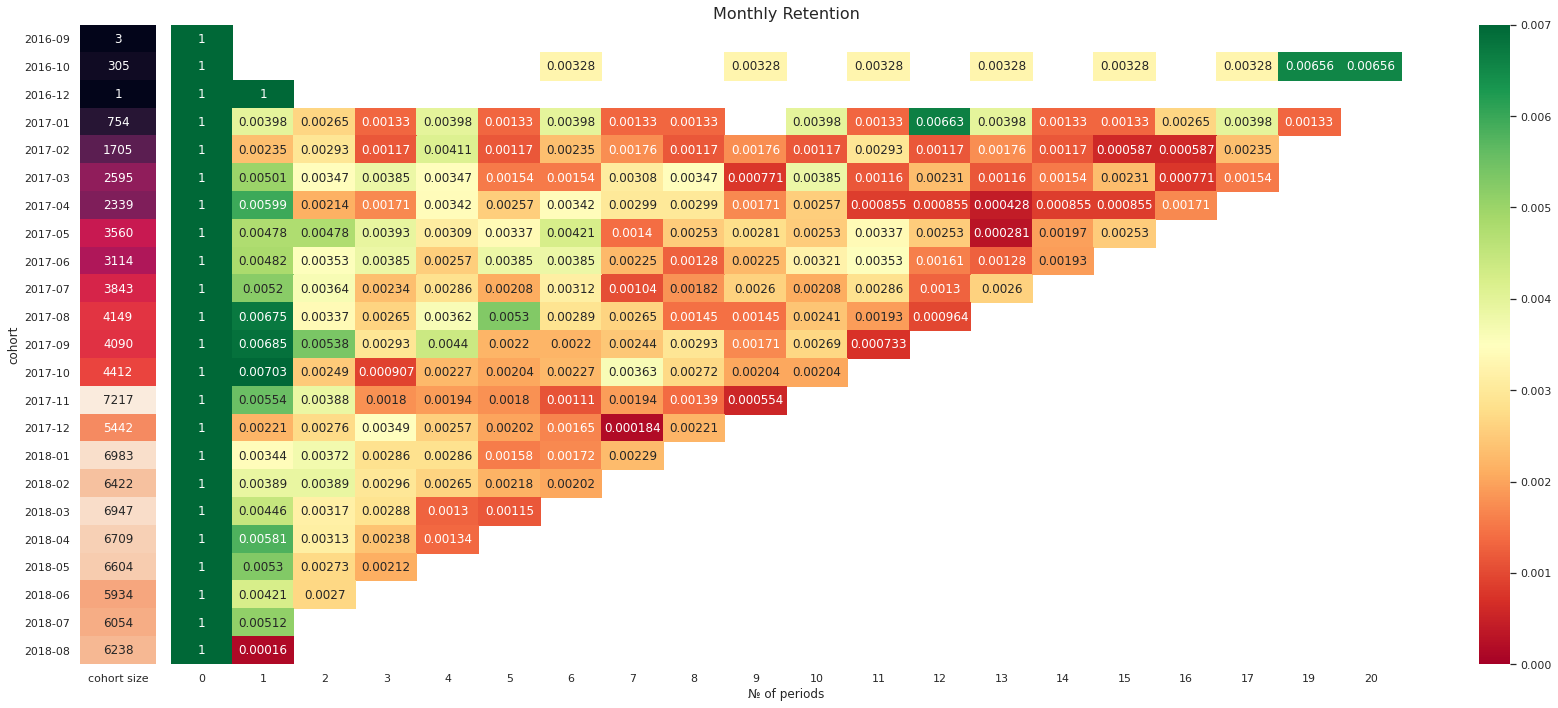

In [78]:
# Строим heatmap с retention и количеством пользователей
fig, ax = plt.subplots(1, 2, figsize=(24, 10), sharey=True,\
                       gridspec_kw={'width_ratios': [1, 20]})
sns.heatmap(retention_matrix,
            robust=False,
            mask=retention_matrix.isnull(),
            fmt='.3g',
            annot=True,
            vmin=0, 
            vmax=0.007,
            cmap='RdYlGn',
            ax=ax[1])
ax[1].set_title('Monthly Retention', fontsize=16)
ax[1].set(xlabel='№ of periods', ylabel='')
cohort_size_df = pd.DataFrame(cohort_size) \
                             .rename(columns={0: 'cohort size'})
sns.heatmap(cohort_size_df,
            annot=True,
            cbar=False,
            fmt='g',
            ax=ax[0])
fig.tight_layout()

Ответ:
Когортой с самым высоким retention на 3й месяц в периоде с января по декабрь, является группа пользователей "2017-05" с CRR=0.003933

# 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. (35 баллов)

In [79]:
# Создаем таблицу с необходимой аггрегацией для RFM анализа
rfm_df = overall_df.query('payed == 1') \
                   .groupby(['order_id', 
                              'order_purchase_timestamp', 
                              'customer_unique_id'], 
                               as_index=False) \
                   .agg({'price': 'sum'})

In [80]:
# проверяем на пропуски
rfm_df.isna().sum()

order_id                    0
order_purchase_timestamp    0
customer_unique_id          0
price                       0
dtype: int64

In [81]:
# Создаем виртуальную дату(+1 день от последней покупки)
# чтобы значения timedelta в последющих вычислениях не "убежали" далеко к текущей дате
NOW = rfm_df.order_purchase_timestamp.max() + timedelta(days=1)
# задаем период в днях: разница между последней датой покупки и первой
# period = (rfm_df.order_purchase_timestamp.max() 
#         - rfm_df.order_purchase_timestamp.min()).days

In [82]:
# создаем колонку с количеством дней от виртуальной даты NOW (см. ранее) до даты покупки
rfm_df['DaysSinceOrder'] = rfm_df.order_purchase_timestamp.apply(lambda x: (NOW - x).days)

In [83]:
# создаем новый аггрегированный датафрейм со значениями RFM как задано в задании
rfm = rfm_df.groupby('customer_unique_id', as_index=False) \
            .agg({'DaysSinceOrder':'min', 
                  'order_id': 'count',
                  'price': 'sum'}) \
            .rename(columns={'DaysSinceOrder': 'Recency',
                            'order_id': 'Frequency',
                            'price': 'Monetary'})
rfm

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...,...
94683,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
94684,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
94685,ffff371b4d645b6ecea244b27531430a,573,1,89.90
94686,ffff5962728ec6157033ef9805bacc48,124,1,115.00


In [84]:
# Попробуем разбить все наши показатели по квантилям (20%-40%-60%-80%) на 5 частей:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 98.0, 0.4: 182.0, 0.6: 273.0, 0.8: 388.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Видим, что Frequency по всем квантилям равен 1 - т.е. в последнем квантиле (>1) окажутся все возможные различия.
Можно разделить на 5 групп следующим образом:
1. Сумма покупок = 1 - т.е. все кто хоть раз совершил у нас покупку
2. Сумма покупок = 2 - т.е. те, кто знает наш сервис и пожелал повторить опыт работы с ним
3. Сумма покупок = 3 - т.е. те кто периодически проявляет активность в нашем магазине
4. Сумма покупок от 4 до 6 вкл. - т.е. те кто достаточно активно пользуется нашим сервисом
5. Сумма покупок более 6 - оставшаяся наиболее активная и лояльная часть пользователей

Также по Recency можно сделать другое распределение (пусть не такое точное в плане равномерного распределения), но более осмысленное по временным границам.
Например:
1. Совершение покупки за последний месяц (от 0 до 30 дней вкл.)
2. Совершение покупки за последний квартал (от 31 до 120 дней вкл.)
3. Совершение покупки за последние полгода (от 121 до 180 дней вкл.)
4. Совершение покупки за последний год (от 181 до 365 дней вкл.)
5. Совершение покупки за последний год (более 365 дней)

Оставим только распределение Monetary по квантилям как есть - это наилучший способ разделить всех пользователей (равноудаленно) по привлеченному доходу

In [85]:
# Создаем функции для разбивки по ранее описанным границам
def r_score(x):
    if x <= 30:
        return 5
    elif x <= 120:
        return 4
    elif x <= 180:
        return 3
    elif x <= 365:
        return 2
    else:
        return 1

def f_score(x, c):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    elif x <= 6:
        return 4
    else:
        return 5
    
def m_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [86]:
# создаем новые ранговые колонки применяя функции по ранее определенным границам
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x, 'Monetary'))

In [87]:
# "складываем" отдельные значения R, F и M в единый признак(сегмент)
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,5,215


In [88]:
# создаем некоторую карту обозначений(толкований) принадлежности ранее заданных сегментов
segt_map = {
    r'[1-2][1-2]': 'неактивны или ушли', #те кто редко покупает и совершил не более 2 покупок
    r'[1-2][3-4]': 'в зоне риска', # те кто давно покупал, но совершил от 3 до 6 покупок
    r'[1-2]5': 'нельзя потерять', # те кто совершил много покупок, но давно не покупал
    r'3[1-2]': 'малоактивные', # те кто совершил покупку до полугода назад, но более не повторяет
    r'33': 'нужно внимание', # пограничные пользователи, нужно работать
    r'[3-4][4-5]': 'лояльные', # те кто относительно часто покупает и активен по текущий момент
    r'41': 'новые, потенциально активные', # те кто совершили покупку 1 в последнем квартале
    r'51': 'новые', # те кто совершил 1 покупку за последний месяц
    r'[4-5][2-3]': 'потенциально лояльные', # активные и совершившие несколько покупок
    r'5[4-5]': 'лучшие' # максимально активные и лояльные
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414,"новые, потенциально активные"
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,"новые, потенциально активные"
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,неактивны или ушли
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211,неактивны или ушли
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,5,215,неактивны или ушли


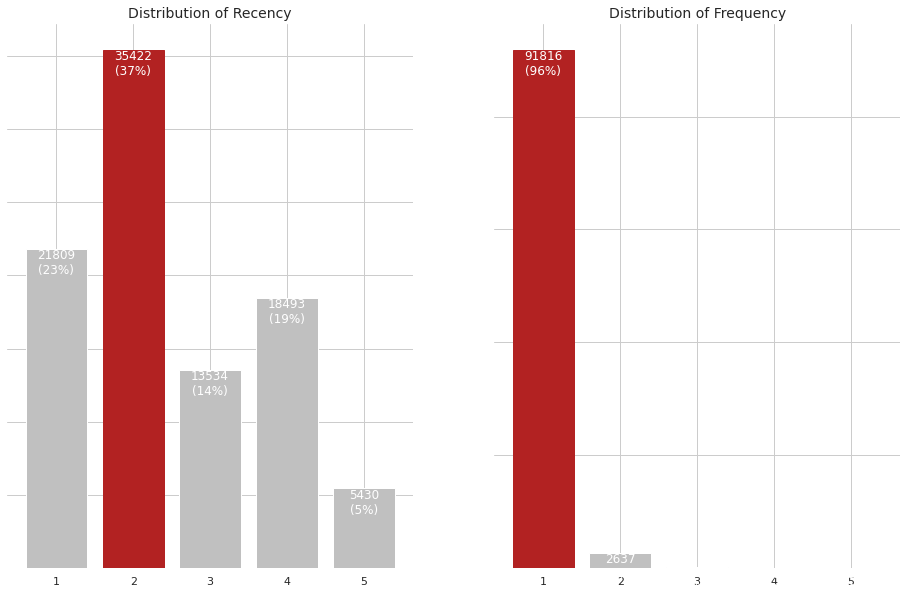

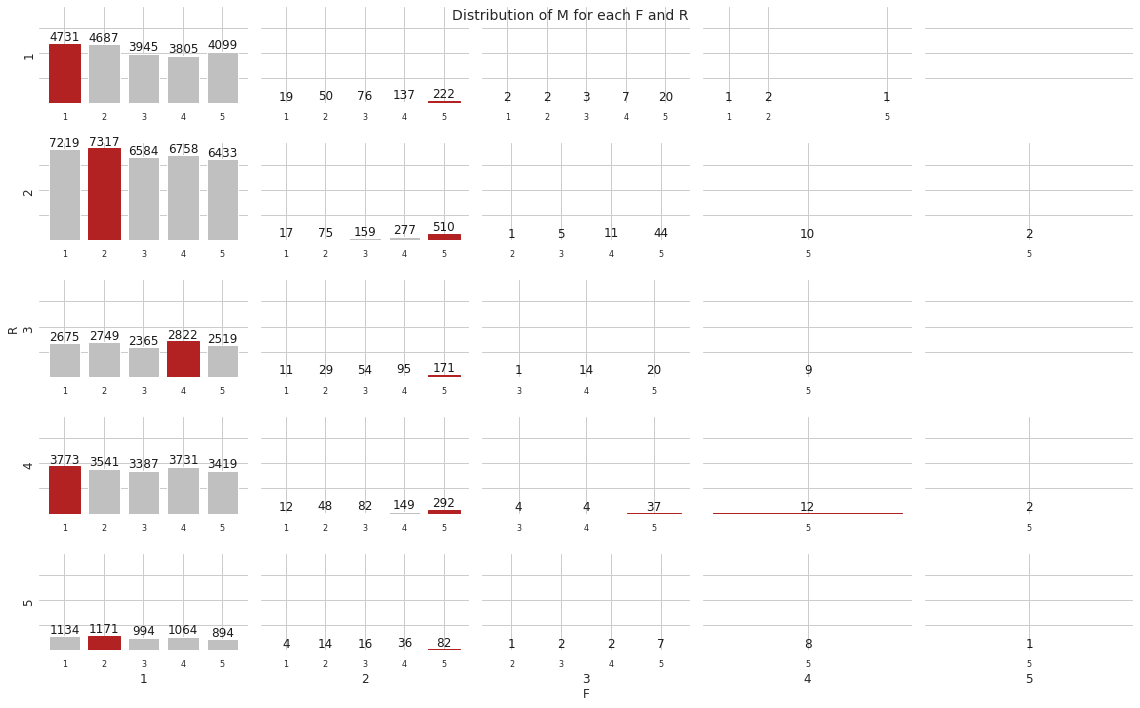

In [89]:
# строим график распрделения покупателей по сегментам R и F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# строим графики распределения доходов M относительно R|F категорий
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(16, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

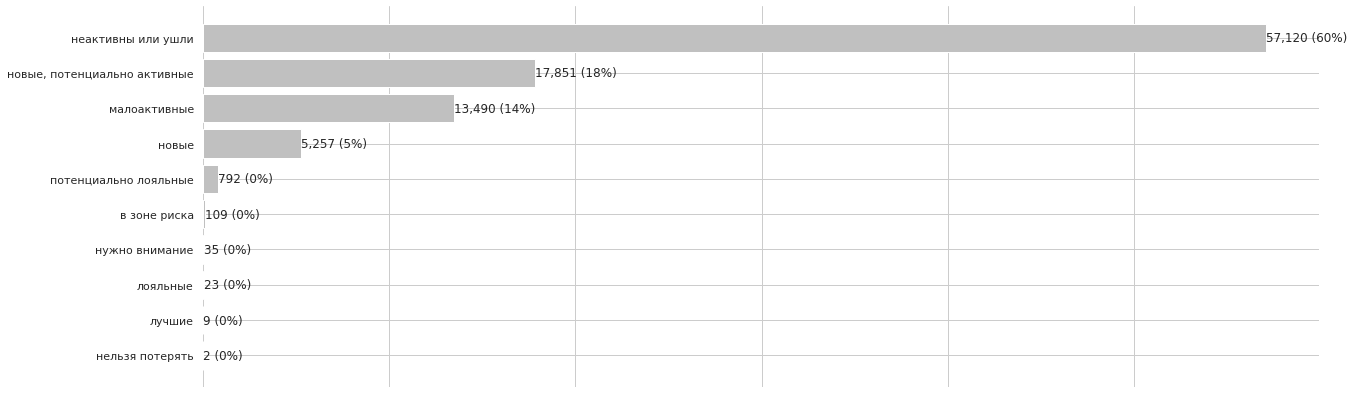

In [90]:
# строим график распределения количества покупателей для каждого сегмента
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Возможно, товары продающиеся в этом интернет-магазине, не являются предметами повседневного спроса.
Условно говоря "холодильники" или "кондиционеры" не каждый месяц или год покупают. Поэтому CRR невысокий и покупатель "не возвращается".
Если посмотреть на вес товаров (следующая ячейка), то основное распределение приходится на товары с весом от 13 до 21 (кг?) - медиана 16 (кг?)
Это говорит от том, что вещи достаточно тяжелые. Это может быть мебель, специфичные детали/узлы или предметы декора(статуи). При чем часть товаров имеет очень высокий вес.

Не зная специфику товаров сложно сделать вывод об успешности площадки.
В связи с этим и сегментация RFM могла бы быть иной, более адаптированной к специфике товаров.\
Например возможно стоило сократить колтичество сегментов по Frequency\
Тем не менее:
1. Активность пользователей(количество продаж) за рассматриваемый период (2 года) имеют положительную динамику.
2. Основной доход приносят разовые покупатели.
3. Также видно, что большая часть дохода пришла от разовых покупателей последнего года и квартала.

Основные выводы: 
1. Этот интернет магазин еще развивается и набирает покупателей (всего 2 года жизни).
2. Несмотря на то, что лояльность основной части пользователей кажется низкой, речь возможно идет о товарах долгосрочного использования.
3. Поэтому сейчас самое время проводить маркетинговые кампании нацеленные как на 40% (см. барплот выше) более активных пользователей (на удержание), так и на разовых (побуждение вернуться).

Для каждой подгруппы могут быть применены свои стратегии:
1. Уже совершившим покупки разовым покупателям предложить купоны и скидки по приводу нового покупателя(друга). Это увеличит приток новых и повысит лояльность уже имеющегося.
2. Уже лояльным покупателям предложить особые условия. Рассрочки, скидки, оплату доставки?
3. Пограничных покупатлей держать в тонусе уведомлениями с предложениями о "сезонных" или временных(горящих-ограниченных во времени) скидках на товары, чтобы побуждать интерес.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


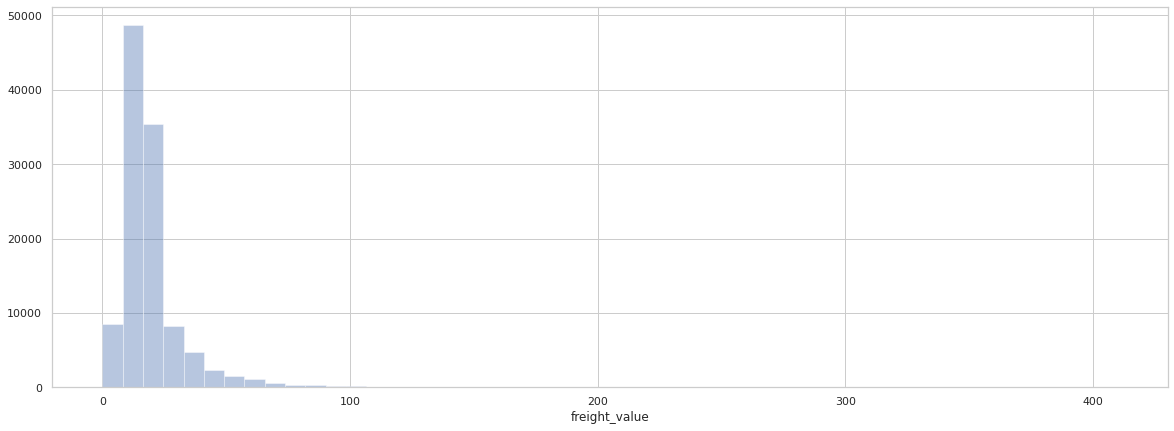

In [91]:
# график распределения весов всех заказов
sns.distplot(overall_df.freight_value, kde=False)

In [92]:
# квартили, среднее, max, min для весов в заказах
overall_df.freight_value.describe()

count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64